<a href="https://colab.research.google.com/github/danielahernandz/Series-de-tiempo-avanzado/blob/main/ARI_SARI_MAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
# from statsmodels.tsa.arima_model as ARMA
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

In [ ]:
raw_csv_data = pd.read_csv('Index2018.csv')
df_comp = raw_csv_data
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

df_comp['market_value']= df_comp.ftse

# del df_comp['spx']
# del df_comp['dax']
# del df_comp['ftse']
# del df_comp['nikkei']

#Datos de train y test
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

##LLR Test

In [ ]:
#Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

def LLR_test(model_1, model_2, DF=1):
  #hallamos las log-verosimilitudes de los modelos para ello usamos el metodo .llf
  L1 = model_1.llf
  L2 = model_2.llf
  LR = (2*(L2-L1)) #Estadistico
  p = chi2.sf(LR, DF).round(3) #distribución del estadistico es una CHI2, por el estadiscito los grado de libertad y se redondea a  decimales.
  return p

Creating returns

In [ ]:
df['returns'] = df.market_value.pct_change(1)*100

#ARIMA (1,1,1)
Desventaja perdida de datos por volver estacionaria, más costosos computacionalmente, inestabilidad númerica.

In [ ]:
#Integración: transformación de datos subyacentes.
modelarima= ARIMA(df.market_value, order=(1,1,1))
resultarima= modelarima.fit()
resultarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27604.005
Date:                Tue, 13 Jun 2023   AIC                          55214.010
Time:                        23:05:06   BIC                          55233.574
Sample:                    01-07-1994   HQIC                         55220.866
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7459      0.059     12.653      0.000       0.630       0.861
ma.L1         -0.7919      0.053    -14.924      0.000      -0.896      -0.688
sigma2      3498.7750     40.933     85.476      0.000    3418.548    3579.002
===================================================================================
Ljung-Box (L1) (Q):                   2.63   Jarque-Bera (JB):              3326.22
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Residuals of the ARIMA(1,1,1)

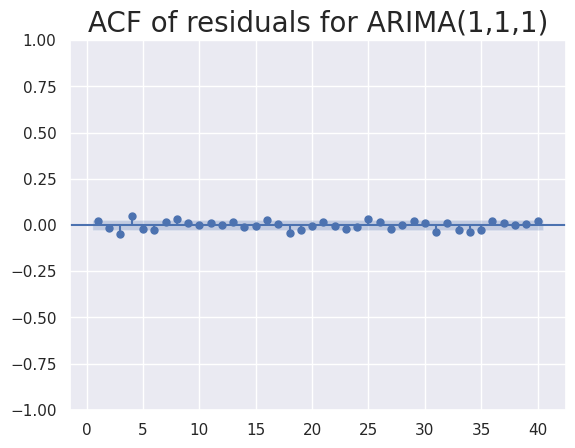

In [ ]:
df['residuos111'] = resultarima.resid.iloc[:]
sgt.plot_acf(df.residuos111[1:], zero= False, lags=40)
plt.title('ACF of residuals for ARIMA(1,1,1)',size=20)
plt.show()

#Retrasos de 3 y 4 días son altamente significativos.

#Higher-Lag ARIMA Models

In [ ]:
modelarima112= ARIMA(df.market_value, order=(1,1,2))
resultarima112= modelarima112.fit()
modelarima113= ARIMA(df.market_value, order=(1,1,3))
resultarima113= modelarima113.fit()
modelarima211= ARIMA(df.market_value, order=(2,1,1))
resultarima211= modelarima211.fit()
modelarima311= ARIMA(df.market_value, order=(3,1,1))
resultarima311= modelarima311.fit()
modelarima312= ARIMA(df.market_value, order=(3,1,2))
resultarima312= modelarima312.fit() #?

In [ ]:
print("\n ARIMA(1,1,1): \tLL = ", resultarima.llf, "\tAIC = ", resultarima.aic)
print("\n ARIMA(1,1,2): \tLL = ", resultarima112.llf, "\tAIC = ", resultarima112.aic)
print("\n ARIMA(1,1,3): \tLL = ", resultarima113.llf, "\tAIC = ", resultarima113.aic)
print("\n ARIMA(2,1,1): \tLL = ", resultarima211.llf, "\tAIC = ", resultarima211.aic)
print("\n ARIMA(3,1,1): \tLL = ", resultarima311.llf, "\tAIC = ", resultarima311.aic)
print("\n ARIMA(3,1,2): \tLL = ", resultarima312.llf, "\tAIC = ", resultarima312.aic)


 ARIMA(1,1,1): 	LL =  -27604.00511572735 	AIC =  55214.0102314547

 ARIMA(1,1,2): 	LL =  -27600.40763254081 	AIC =  55208.81526508162

 ARIMA(1,1,3): 	LL =  -27590.723481950256 	AIC =  55191.44696390051

 ARIMA(2,1,1): 	LL =  -27600.130551053444 	AIC =  55208.26110210689

 ARIMA(3,1,1): 	LL =  -27592.336116473074 	AIC =  55194.67223294615

 ARIMA(3,1,2): 	LL =  -27590.920318056138 	AIC =  55193.840636112276


In [ ]:
print("\nLLR test p-value = " + str (LLR_test (resultarima312, resultarima113))) #modelos similares elegimos 113 por menor AIC
print("\nLLR test p-value = " + str (LLR_test (resultarima112, resultarima113))) #Modelo 113 es mejor que 112


LLR test p-value = 0.53

LLR test p-value = 0.0


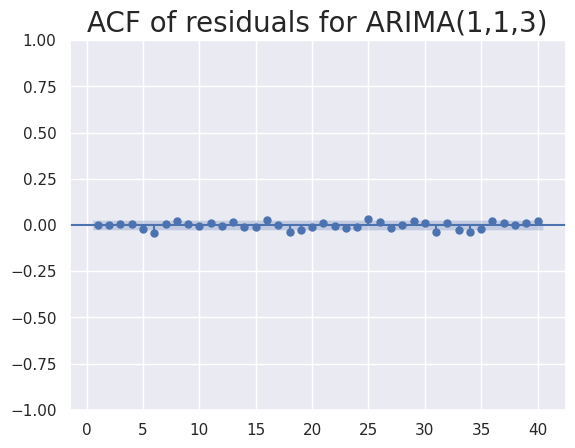

In [ ]:
df['residual113'] = resultarima113.resid
sgt.plot_acf(df.residual113[1:], zero= False, lags= 40)
plt.title('ACF of residuals for ARIMA(1,1,3)', size= 20)
plt.show()
#Observamos que el rezago de 5 y 6 días es importante

In [ ]:
modelarima511= ARIMA(df.market_value, order=(5,1,1))
resultarima511= modelarima511.fit()
resultarima511.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -27586.845
Date:                Tue, 13 Jun 2023   AIC                          55187.689
Time:                        23:06:06   BIC                          55233.338
Sample:                    01-07-1994   HQIC                         55203.685
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4006      0.153      2.618      0.009       0.101       0.701
ar.L2         -0.0444      0.011     -4.071      0.000      -0.066      -0.023
ar.L3         -0.0542      0.013     -4.226      0.000      -0.079      -0.029
ar.L4          0.0587      0.015      3.914      0.000       0.029       0.088
ar.L5         -0.0580      0.009     -6.337      0.000      -0.076      -0.040
ma.L1         -0.4208      0.153     -2.743      0.006      -0.721      -0.120
sigma2      3479.0027     41.909     83.013      0.000    3396.862    3561.143
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3060.40
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
print("\n ARIMA(5,1,1): \tLL = ", resultarima511.llf, "\tAIC = ", resultarima511.aic)
print("\n ARIMA(1,1,3): \tLL = ", resultarima113.llf, "\tAIC = ", resultarima113.aic)
#Se prefiere el modelo de orden 5,1,1 por mejores propiedades
print("\nLLR test p-value = " + str (LLR_test (resultarima511, resultarima113))) # 1.0 modelo 113 es similar a 511
print("\nLLR test p-value = " + str (LLR_test (resultarima113, resultarima511))) #0.005 modelo 511 es diferente signifivativamente de 113


 ARIMA(5,1,1): 	LL =  -27586.84460959241 	AIC =  55187.68921918482

 ARIMA(1,1,3): 	LL =  -27590.723481950256 	AIC =  55191.44696390051

LLR test p-value = 1.0

LLR test p-value = 0.005


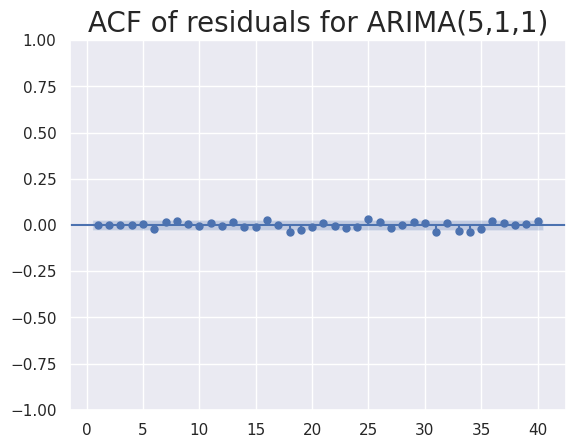

In [ ]:
df['residual511'] = resultarima511.resid
sgt.plot_acf(df.residual511[1:], zero= False, lags= 40)
plt.title('ACF of residuals for ARIMA(5,1,1)', size= 20)
plt.show()

#Models with Higher Levels of Integration

Confiamos en la integración cuando nuestra serie no proviene de un proceso estacionario, ya que esto convierte la serie No estacionaria en Estacionaria.

In [ ]:
df['delta_prices']= df.market_value.diff(1)  #le pasamos un retraso a las diferencias

In [ ]:
model_delta111= ARIMA(df.delta_prices[1:], order=(1,0,1))
result_delta111 = model_delta111.fit()
result_delta111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           delta_prices   No. Observations:                 5020
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27603.666
Date:                Tue, 13 Jun 2023   AIC                          55215.333
Time:                        23:10:30   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5639      0.753      0.749      0.454      -0.911       2.039
ar.L1          0.7476      0.059     12.673      0.000       0.632       0.863
ma.L1         -0.7937      0.053    -14.871      0.000      -0.898      -0.689
sigma2      3496.6352     41.191     84.888      0.000    3415.902    3577.368
===================================================================================
Ljung-Box (L1) (Q):                   2.64   Jarque-Bera (JB):              3327.38
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_delta111= ARIMA(df.market_value[1:], order=(1,1,1))
result_delta111 = model_delta111.fit()
result_delta111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27599.000
Date:                Tue, 13 Jun 2023   AIC                          55203.999
Time:                        23:21:10   BIC                          55223.562
Sample:                    01-10-1994   HQIC                         55210.854
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7466      0.059     12.692      0.000       0.631       0.862
ma.L1         -0.7925      0.053    -14.970      0.000      -0.896      -0.689
sigma2      3497.8883     40.914     85.494      0.000    3417.698    3578.078
===================================================================================
Ljung-Box (L1) (Q):                   2.61   Jarque-Bera (JB):              3323.83
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sts.adfuller(df.delta_prices[1:])
# p-valor= 0.0 se rechaza H0, por lo tanto la serie es estacionaria

(-32.244093495707475,
 0.0,
 5,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54845.96104221891)

#ARIMAX
Este modelo permite incorporar variables exogenas que ambien afectan a la serie + BY.

In [ ]:
datainicial = pd.read_csv('Index2018.csv')
dataintermedia = pd.read_csv('Index2018.csv')

In [ ]:
# dataintermedia.date = pd.to_datetime(dataintermedia.date, dayfirst = True)
# dataintermedia.set_index("date", inplace=True)
# dataintermedia = dataintermedia.asfreq('b')
# dataintermedia = dataintermedia.fillna(method='ffill')

date_= dataintermedia
date_

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.900000,2224.95,3445.980000,18124.01
1994-01-10,475.270000,2225.00,3440.580000,18443.44
1994-01-11,474.130000,2228.10,3413.770000,18485.25
1994-01-12,474.170000,2182.06,3372.020000,18793.88
1994-01-13,472.470000,2142.37,3360.010000,18577.26
...,...,...,...,...
2018-01-23,2839.130362,13559.60,7731.827774,24124.15
2018-01-24,2837.544008,13414.74,7643.428966,23940.78
2018-01-25,2839.253031,13298.36,7615.839954,23669.49


In [ ]:
# dfexog= datainicial
dfexog.date = pd.to_datetime(dfexog.date, dayfirst = True)
dfexog.set_index("date", inplace=True)
dfexog = dfexog.asfreq('b')
dfexog = dfexog.fillna(method='ffill')

In [ ]:
dfexog

,spx,dax,nikkei
date,,,
1994-01-07,469.900000,2224.95,18124.01
1994-01-10,475.270000,2225.00,18443.44
1994-01-11,474.130000,2228.10,18485.25
1994-01-12,474.170000,2182.06,18793.88
1994-01-13,472.470000,2142.37,18577.26
...,...,...,...
2018-01-23,2839.130362,13559.60,24124.15
2018-01-24,2837.544008,13414.74,23940.78
2018-01-25,2839.253031,13298.36,23669.49


In [ ]:
#Variable exogena multivariante
model111_dfexog = ARIMA(date_.ftse, exog= dfexog, order=(1,1,1))
result111_dfexog = model111_dfexog.fit()
result111_dfexog.summary()  #betaY

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6277
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -31409.394
Date:                Wed, 14 Jun 2023   AIC                          62830.789
Time:                        00:01:01   BIC                          62871.256
Sample:                    01-07-1994   HQIC                         62844.810
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            0.6076      0.028     21.718      0.000       0.553       0.662
dax            0.4647      0.004    103.810      0.000       0.456       0.473
nikkei         0.0247      0.002     13.474      0.000       0.021       0.028
ar.L1          0.4628      0.081      5.726      0.000       0.304       0.621
ma.L1         -0.5413      0.078     -6.973      0.000      -0.693      -0.389
sigma2      1302.5763     14.287     91.175      0.000    1274.575    1330.577
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):              3934.42
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model111_Xspx = ARIMA(df.market_value, exog= df.spx, order=(1,1,1))
result11_Xspx = model111_Xspx.fit()
result11_Xspx.summary()  #betaY

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26693.392
Date:                Tue, 13 Jun 2023   AIC                          53394.784
Time:                        23:24:59   BIC                          53420.869
Sample:                    01-07-1994   HQIC                         53403.925
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.6928      0.035     76.407      0.000       2.624       2.762
ar.L1          0.2571      0.029      8.812      0.000       0.200       0.314
ma.L1         -0.5460      0.025    -21.791      0.000      -0.595      -0.497
sigma2      2433.0771     27.350     88.961      0.000    2379.472    2486.682
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              4423.90
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Compara los resultados con el modelo de la clase anterior que sólo contiene como variable exógena los precios de SP500.
# Obtén los valores de la verosimilitud de ambos, el AIC y mira la significación de los coeficientes estimados. ¿A qué conclusión llegas?

print("\n ARIMAXspx(1,1,1): \tLL = ", result11_Xspx.llf, "\tAIC = ", result11_Xspx.aic)
print("\n ARIMAMULTI(1,1,1): \tLL = ", result111_dfexog.llf, "\tAIC = ", result111_dfexog.aic)
print("\nLLR test p-value = " + str (LLR_test (result11_Xspx, result111_dfexog)))
print("\nLLR test p-value = " + str (LLR_test (result111_dfexog, result11_Xspx)))

#Es  mejor modelo el modelo que solo tiene en cuenta una variable exogena al multivariante, ya que tiene un menor AIC y un LL mayor.
#Además comparando el p-valor de verosilimitud se prefiere el modelo Xspx


 ARIMAXspx(1,1,1): 	LL =  -26693.392125249866 	AIC =  53394.78425049973

 ARIMAMULTI(1,1,1): 	LL =  -31409.394318007508 	AIC =  62830.788636015015

LLR test p-value = 1.0

LLR test p-value = 0.0


#SARIMAX

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [63]:
model_sarimax = SARIMAX(df.market_value, exog = df.spx, order= (1,0,1), seasonal_order =(2,0,1,5))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26712.780
Date:                           Wed, 14 Jun 2023   AIC                          53439.560
Time:                                   01:50:51   BIC                          53485.210
Sample:                               01-07-1994   HQIC                         53455.556
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7037      0.035     76.430      0.000       2.634       2.773
ar.L1          0.9998      0.001   1913.710      0.000       0.999       1.001
ma.L1         -0.3101      0.010    -32.622      0.000      -0.329      -0.291
ar.S.L5        0.9652      0.011     90.117      0.000       0.944       0.986
ar.S.L10       0.0344      0.010      3.445      0.001       0.015       0.054
ma.S.L5       -0.9985      0.005   -187.184      0.000      -1.009      -0.988
sigma2      2442.5692     28.460     85.826      0.000    2386.789    2498.349
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):              4212.72
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""